In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import precision_score, recall_score, accuracy_score
import random
import matplotlib.pyplot as plt

def load_data():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    return (x_train, y_train), (x_test, y_test)

In [2]:
def create_pairs(x, y):
    pairs = []
    labels = []
    num_classes = 10
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    for idx1 in range(len(x)):
        # Positive pair
        x1 = x[idx1]
        label = y[idx1]
        idx2 = random.choice(digit_indices[label])
        x2 = x[idx2]
        pairs += [[x1, x2]]
        labels += [1]

        # Negative pair
        negative_label = random.randint(0, num_classes - 1)
        while negative_label == label:
            negative_label = random.randint(0, num_classes - 1)
        idx2 = random.choice(digit_indices[negative_label])
        x2 = x[idx2]
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)


In [3]:
def create_siamese_network(input_shape):
    def base_network(input_shape):
        model = models.Sequential()
        model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        return model

    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    base_model = base_network(input_shape)
    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([processed_a, processed_b])
    output = layers.Dense(1, activation='sigmoid')(distance)

    model = models.Model(inputs=[input_a, input_b], outputs=output)
    return model


def contrastive_loss(y_true, y_pred, margin=1):
    y_true = tf.cast(y_true, y_pred.dtype)
    squared_pred = tf.square(y_pred)
    squared_margin = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * squared_pred + (1 - y_true) * squared_margin)



In [4]:
def train_model(model, pairs_train, labels_train, pairs_test, labels_test):
    model.compile(optimizer='adam', loss=contrastive_loss, metrics=['accuracy'])
    history = model.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train,
                        validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
                        epochs=10, batch_size=128)
    return history


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.1790 - loss: 0.1258 - val_accuracy: 0.1044 - val_loss: 0.0794
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.0948 - loss: 0.0722 - val_accuracy: 0.0903 - val_loss: 0.0689
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.0772 - loss: 0.0590 - val_accuracy: 0.0809 - val_loss: 0.0615
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.0652 - loss: 0.0500 - val_accuracy: 0.0781 - val_loss: 0.0590
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.0548 - loss: 0.0429 - val_accuracy: 0.0715 - val_loss: 0.0545
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.0483 - loss: 0.0377 - val_accuracy: 0.0690 - val_loss: 0.0530
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.0427 - loss: 0.0336 - val_accuracy: 0.0693 - val_loss: 0.0530
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.0381 - loss: 0.0303 - 

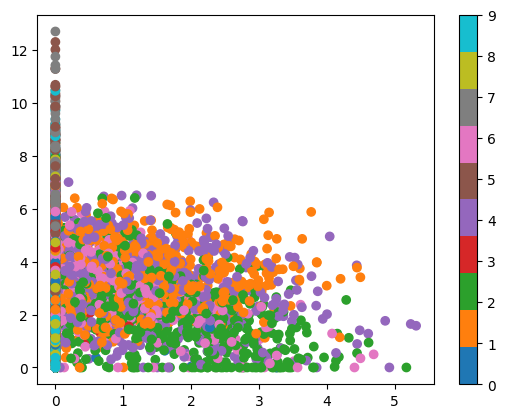

In [5]:
def evaluate_model(model, pairs_test, labels_test):
    predictions = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
    predictions = np.round(predictions).flatten()
    precision = precision_score(labels_test, predictions)
    recall = recall_score(labels_test, predictions)
    accuracy = accuracy_score(labels_test, predictions)
    return precision, recall, accuracy


def visualize_results(x_test, y_test, model):
    test_embeddings = model.layers[2].predict(x_test)
    plt.scatter(test_embeddings[:, 0], test_embeddings[:, 1], c=y_test, cmap='tab10')
    plt.colorbar()
    plt.show()


if __name__ == "__main__":
    (x_train, y_train), (x_test, y_test) = load_data()
    pairs_train, labels_train = create_pairs(x_train, y_train)
    pairs_test, labels_test = create_pairs(x_test, y_test)

    input_shape = x_train.shape[1:] + (1,)
    x_train = x_train[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    pairs_train = pairs_train.astype('float32')
    pairs_test = pairs_test.astype('float32')

    siamese_model = create_siamese_network(input_shape)
    train_model(siamese_model, pairs_train, labels_train, pairs_test, labels_test)

    precision, recall, accuracy = evaluate_model(siamese_model, pairs_test, labels_test)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")

    visualize_results(x_test, y_test, siamese_model)